In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, f1_score

from keras import Sequential
from keras.layers import Dense, Input

pd.options.display.max_columns = None

In [270]:
def load() -> pd.DataFrame:
    df = pd.read_pickle("data.pickle")

    outsample = df[df["Date Announced"] > "2020-01-01"] # true out of sample, do not touch
    insample = df[df["Date Announced"] <= "2020-01-01"]

    return outsample, insample 

_, df = load()

In [271]:
df.head()

,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Target Ticker Symbol,Target CUSIP,Target Industry Sector,Acquiror Name,Acquiror Ticker Symbol,Acquiror CUSIP,Acquiror Industry Sector,% sought,Value of Transaction ($mil),Enterprise Value ($mil),Equity Value ($mil),Ratio of Offer Price to EPS,"Target and Acquiror Financial Advisor Fees, Total ($mil)",Target Share Price 1 Day Prior to Announcement ($),Ratio of Deal Value to Sales,% seeking to own after trans- action,Exchange Ratio,Equity Value at Announcement ($mil),Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Net Debt ($ mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Target R&D One Year Prior ($ mil),Target Debt Ratio,Target Debt Ratio Two Years Prior,Price / Net Assets Per Share,Share- holders Equity/ Total Assets,Target Return On Assets LTM,Return On Total Equity,Target Return On Equity LTM,Target Return On Equity One Year Prior,Target Debt/ Capital.,Target Long- Term Debt/ Share- holders Equity,Long Term Debt/ Total Assets,Firm Value/ EBIT,Firm Value/ EBITDA,Firm Value/ Sales,Implied Value/ Target Common Equity,Firm Value/ Assets- Cash,Equity Value/ Common Equity,Value / Net Assets,Common Equity Multiple,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Deal Value to Net Income,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Ratio of Enterprise Value to Net Income,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Ratio of Equity Value to Net Income,Acquiror Cvt Debt LTM ($ mil),Acquiror Curr Assets LTM ($ mil),Acquiror Curr Liabilities LTM ($ mil),Acquiror Common Equity LTM ($ mil),Acquiror Earnings Per Share LTM ($),Acquiror EBIT LTM ($ mil),Acquiror EBITDA LTM ($ mil),Acquiror Net Assets ($mil),Acquiror Net Debt LTM ($ mil),Acquiror Net Income Last Twelve Months ($Mil),Acquiror Net Sales ($mil),Target Closing Price 1 Day After Ann Date ($),S&P 500 Closing Price 1 Day After Announcement,S&P 500 Closing Price 1 Day Before Announcement,Price Per Share,Acquiror Closing Price 90 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Share Price 1 Week Prior to Announcement ($),Target Share Price 4 Weeks Prior to Announcement ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,Acquiror is public,Success
0,2017-01-03,NaT,2017-01-23,3056656020,InVivo Therapeutics Holdings,NVIV,46186M,"Measuring, Medical, Photo Equipment; Clocks",PixarBio Corp,PXRB,0F1095,Amusement and Recreation Services,100.0,77.000,NaN,NaN,NaN,NaN,4.20,NaN,100.0,NaN,NaN,NaN,-24.063,-23.4,-23.4,28.9,34.8,-23.510,-32.127,677.6,28.949,-566.5814,12.6,0.2,0.2,2.7,83.23,-67.38,NaN,NaN,-80.96,0.03,0.03,2.45,NaN,NaN,NaN,NaN,NaN,NaN,2.7,2.660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.45,2270.75,2238.83,NaN,NaN,4.00,4.35,4.75,NaN,NaN,NaN,True,False
1,2017-01-03,2017-04-24,NaT,3056489020,Kopin Corp,KOPN,500600,Electronic and Electrical Equipment,Goertek Inc,002241,37883H,Electronic and Electrical Equipment,11.4,24.700,139.803,217.001,NaN,NaN,2.84,9.584,11.4,NaN,217.001,22.643,-28.173,-19.9,-23.4,74.2,87.8,-27.179,-77.198,1.1,74.044,-0.3659,16.0,0.2,0.1,2.9,84.30,-26.68,NaN,NaN,-31.65,NaN,NaN,NaN,NaN,NaN,6.18,NaN,13.16,2.931,2.9,2.931,NaN,NaN,NaN,6.174,NaN,NaN,NaN,9.584,NaN,NaN,NaN,NaN,1702.13,1327.40,1503.06,0.0779,283.25,414.85,1503.5,612.63,237.9,2778.0,3.50,2270.75,2238.83,NaN,4.90,3.98,2.96,2.73,NaN,NaN,NaN,True,True
2,2017-01-03,NaT,2017-06-16,3060281020,Tangoe Inc,TNGO,87582Y,Prepackaged Software,Tangoe Inc SPV,NaN,2F1214,"Investment & Commodity Firms,Dealers,Exchanges",75.0,207.204,244.269,275.788,NaN,

## train model (sample)

The model is useless obviously since i just threw everything into fit()
Do some feature engineering + scaling first

In [272]:
X = df.iloc[:,12:-1] 
y = df.iloc[:,-1]

train_len = int(len(df) * 0.75)

In [273]:
X_train = X.iloc[:train_len,:]
y_train = y.iloc[:train_len]

X_test = X.iloc[train_len:,:]
y_test = y.iloc[train_len:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((666, 76), (666,), (222, 76), (222,))

In [274]:
# remove features with too many nans

def sufficient_entries(df: pd.DataFrame, col: str) -> bool:
    # return false if col has >30% nans
    c = df[col]
    return ( c.isin([np.nan]).sum() / len(c) ) <= 0.50


In [275]:
new_cols = [c for c in X_train.columns if sufficient_entries(df, c)]

X_train = X_train[new_cols]
X_test = X_test[new_cols]

X_train.shape, X_test.shape

((666, 65), (222, 65))

In [276]:
X_train.head()

,% sought,Value of Transaction ($mil),Enterprise Value ($mil),Equity Value ($mil),"Target and Acquiror Financial Advisor Fees, Total ($mil)",Target Share Price 1 Day Prior to Announcement ($),Ratio of Deal Value to Sales,% seeking to own after trans- action,Equity Value at Announcement ($mil),Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Net Debt ($ mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Target Debt Ratio,Target Debt Ratio Two Years Prior,Price / Net Assets Per Share,Share- holders Equity/ Total Assets,Target Return On Assets LTM,Target Return On Equity One Year Prior,Target Debt/ Capital.,Target Long- Term Debt/ Share- holders Equity,Long Term Debt/ Total Assets,Firm Value/ EBIT,Firm Value/ EBITDA,Firm Value/ Sales,Implied Value/ Target Common Equity,Firm Value/ Assets- Cash,Equity Value/ Common Equity,Value / Net Assets,Common Equity Multiple,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Acquiror Common Equity LTM ($ mil),Acquiror Earnings Per Share LTM ($),Acquiror EBIT LTM ($ mil),Acquiror EBITDA LTM ($ mil),Acquiror Net Assets ($mil),Acquiror Net Debt LTM ($ mil),Acquiror Net Income Last Twelve Months ($Mil),Acquiror Net Sales ($mil),Target Closing Price 1 Day After Ann Date ($),S&P 500 Closing Price 1 Day After Announcement,S&P 500 Closing Price 1 Day Before Announcement,Price Per Share,Acquiror Closing Price 90 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Share Price 1 Week Prior to Announcement ($),Target Share Price 4 Weeks Prior to Announcement ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,Acquiror is public
0,100.0,77.000,NaN,NaN,NaN,4.20,NaN,100.0,NaN,NaN,-24.063,-23.4,-23.4,28.9,34.8,-23.510,-32.127,677.6,28.949,-566.5814,0.2,0.2,2.7,83.23,-67.38,-80.96,0.03,0.03,2.45,NaN,NaN,NaN,NaN,NaN,NaN,2.7,2.660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.45,2270.75,2238.83,NaN,NaN,4.00,4.35,4.75,NaN,NaN,NaN,True
1,11.4,24.700,139.803,217.001,NaN,2.84,9.584,11.4,217.001,22.643,-28.173,-19.9,-23.4,74.2,87.8,-27.179,-77.198,1.1,74.044,-0.3659,0.2,0.1,2.9,84.30,-26.68,-31.65,NaN,NaN,NaN,NaN,NaN,6.18,NaN,13.16,2.931,2.9,2.931,NaN,NaN,6.174,NaN,NaN,9.584,NaN,NaN,1503.06,0.0779,283.25,414.85,1503.5,612.63,237.9,2778.0,3.50,2270.75,2238.83,NaN,4.90,3.98,2.96,2.73,NaN,NaN,NaN,True
2,75.0,207.204,244.269,275.788,3.6,8.23,1.259,100.0,276.272,219.447,-1.288,-1.6,-4.1,182.4,227.7,8.741,-31.519,4.6,182.392,-0.1089,0.2,0.2,1.5,80.11,-1.81,1.65,0.01,0.01,1.15,NaN,27.95,1.11,1.515,1.28,1.512,1.5,1.515,NaN,31.606,1.113,NaN,27.945,1.257,NaN,31.551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.88,2270.75,2238.83,7.00,NaN,5.44,7.98,7.79,-14.95,-12.28,-10.14,False
3,13.5,371.295,2844.845,2745.113,NaN,1.96,3.918,13.5,2745.113,203.680,-29.969,-246.0,-246.0,-73.8,1135.2,76.079,99.732,-164.9,-73.825,-348.2324,1.1,0.8,NaN,NaN,-21.67,-1044.00,NaN,NaN,NaN,NaN,37.39,13.97,NaN,2.73,NaN,NaN,NaN,NaN,10.489,13.967,NaN,37.393,13.478,NaN,36.082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.08,2269.00,2257.83,NaN,NaN,1.06,1.68,1.02,NaN,NaN,NaN,False
4,100.0,2492.426,3233.107,2493.483,30.0,61.90,2.624,100.0,2492.431,949.794,109.090,-16.0,-34.7,-174.9,1408.9,211.266,739.624,-5.4,-174.930,-1.0801,1.1,1.0,NaN,NaN,-2.46,NaN,1.24,NaN,61.52,29.64,15.30,3.40,NaN,2.54,NaN,NaN,NaN,22.8,11.798,3.404,29.637,15.303,2.625,22.857,11.803,60.88,2.3095,347.74,409.71,60.9,220.16,193.6,2444.5,75.95,2276.98,2270.75,77.25,109.23,NaN,60.75,59.35,24.80,27.16,30.16,True


In [277]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train_imputed.isnull().any().any(), X_test_imputed.isnull().any().any(), X_train_imputed.shape, X_test_imputed.shape

(False, False, (666, 65), (222, 65))

In [278]:
scaler = StandardScaler().fit(X_train_imputed)

X_train_norm = pd.DataFrame(scaler.transform(X_train_imputed), index=X_train_imputed.index, columns=X_train_imputed.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test_imputed), index=X_test_imputed.index, columns=X_test_imputed.columns)

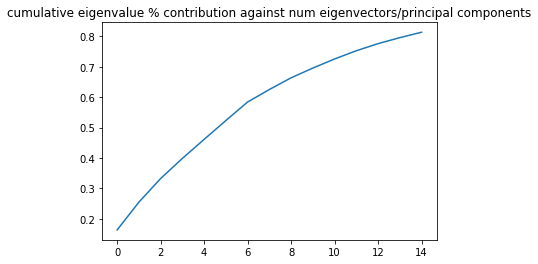

In [279]:
pca = PCA(n_components=15)
pca.fit(X_train_norm)

plt.plot(pca.explained_variance_ratio_.cumsum(), "-")
plt.title("cumulative eigenvalue % contribution against num eigenvectors/principal components")
plt.show()

In [280]:
X_train_pca = pd.DataFrame(pca.transform(X_train_norm), index=X_train_norm.index)
X_test_pca = pd.DataFrame(pca.transform(X_test_norm), index=X_test_norm.index)

X_train_pca.shape, X_test_pca.shape

((666, 15), (222, 15))

In [281]:
## train dummy classifier (predict True for all events)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_pca, y_train)
yhat = dummy.predict(X_test_pca)
dummy.score(X_test_pca, y_test), recall_score(y_test, yhat), f1_score(y_test, yhat)

(0.9504504504504504, 1.0, 0.9745958429561201)

In [282]:
# train classifier

clf = GradientBoostingClassifier()

clf.fit(X_train_pca, y_train)

yhat = clf.predict(X_test_pca)
clf.score(X_test_pca, y_test), recall_score(y_test, yhat), f1_score(y_test, yhat)

# this is worse than just predicting True everytime lol

(0.9324324324324325, 0.976303317535545, 0.964871194379391)